
Wine (White): 4898 samples, 11 features, classes=[3 4 5 6 7 8 9]

Parameter summary per class:
class 3: n=20, prior=0.0041, lambda=74.8361, min_eig(C_reg)=74.8361
class 4: n=163, prior=0.0333, lambda=14.629, min_eig(C_reg)=14.629
class 5: n=1457, prior=0.2975, lambda=10.467, min_eig(C_reg)=10.467
class 6: n=2198, prior=0.4488, lambda=9.00425, min_eig(C_reg)=9.00425
class 7: n=880, prior=0.1797, lambda=5.76446, min_eig(C_reg)=5.76446
class 8: n=175, prior=0.0357, lambda=6.23876, min_eig(C_reg)=6.23876
class 9: n=5, prior=0.0010, lambda=7.36814, min_eig(C_reg)=7.36814

Wine (White): Confusion Matrix (rows=true, cols=pred)
    P3  P4  P5   P6    P7  P8  P9
T3   2   1   0    6     9   2   0
T4   1   0   2   42   117   1   0
T5   1   1  33  423   994   5   0
T6   1   0  25  426  1741   5   0
T7   0   0   0   64   811   5   0
T8   0   0   0   10   160   5   0
T9   0   0   0    0     5   0   0
Wine (White): Estimated P(error) = 0.7393
class 3: error = 0.9000
class 4: error = 1.0000
class 5: 

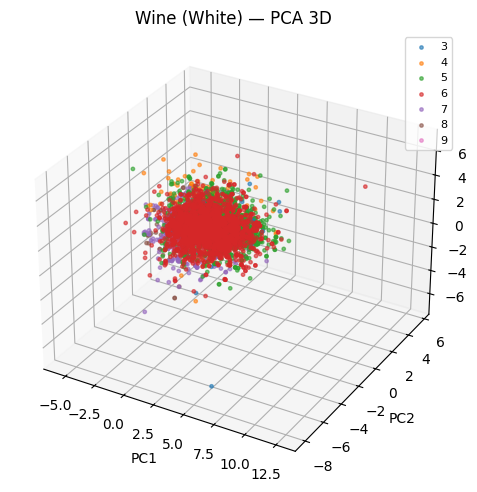


HAR (UCI Smartphones): 10299 samples, 561 features, classes=[1 2 3 4 5 6]

Parameter summary per class:
class 1: n=1722, prior=0.1672, lambda=0.00214862, min_eig(C_reg)=0.00214862
class 2: n=1544, prior=0.1499, lambda=0.00220264, min_eig(C_reg)=0.00220264
class 3: n=1406, prior=0.1365, lambda=0.00302286, min_eig(C_reg)=0.00302286
class 4: n=1777, prior=0.1725, lambda=0.00171383, min_eig(C_reg)=0.00171383
class 5: n=1906, prior=0.1851, lambda=0.00154645, min_eig(C_reg)=0.00154645
class 6: n=1944, prior=0.1888, lambda=0.00214628, min_eig(C_reg)=0.00214628


In [ ]:

import os, io, zipfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def download_file(url: str, dest: Path):
    if dest.exists():
        return dest
    print(f"Downloading: {url}")
    with urllib.request.urlopen(url) as r, open(dest, "wb") as f:
        f.write(r.read())
    return dest

def geometric_mean(vals):
    vals = np.asarray(vals)
    vals = vals[vals > 0]
    return float(np.exp(np.mean(np.log(vals)))) if len(vals) else 0.0

def class_stats(X, y, alpha=0.05, lam_mode="arith"):
    classes, counts = np.unique(y, return_counts=True)
    n, d = X.shape
    priors = {c: counts[i] / n for i, c in enumerate(classes)}
    means, covs, raw_covs, lambdas, min_eigs = {}, {}, {}, {}, {}

    for c in classes:
        Xc = X[y == c]
        mu = Xc.mean(axis=0)
        C = np.cov(Xc.T, bias=False)
        raw_covs[c] = C.copy()
        w = np.linalg.eigvalsh(C)
        nonzero = w[w > 1e-12]
        if lam_mode == "geom":
            lam_base = geometric_mean(nonzero) if len(nonzero) else 0.0
        else:
            rank = len(nonzero)
            lam_base = (np.trace(C) / rank) if rank > 0 else 0.0
        lam = alpha * lam_base
        Creg = C + lam * np.eye(d)
        means[c] = mu
        covs[c] = Creg
        lambdas[c] = float(lam)
        min_eigs[c] = float(np.linalg.eigvalsh(Creg).min())
    return classes, priors, means, covs, raw_covs, lambdas, min_eigs

def gaussian_log_discriminant(x, mu, Sigma, log_prior):
    xc = x - mu
    sign, logdet = np.linalg.slogdet(Sigma)
    if sign <= 0:
        Sigma = Sigma + 1e-7 * np.eye(Sigma.shape[0])
        sign, logdet = np.linalg.slogdet(Sigma)
    quad = xc @ np.linalg.solve(Sigma, xc)
    return log_prior - 0.5 * (logdet + quad)

def bayes_predict(X, classes, priors, means, covs):
    n = X.shape[0]
    yhat = np.empty(n, dtype=classes.dtype)
    class_terms = {}
    for c in classes:
        Sigma = covs[c]
        sign, logdet = np.linalg.slogdet(Sigma)
        if sign <= 0:
            Sigma = Sigma + 1e-7 * np.eye(Sigma.shape[0])
            sign, logdet = np.linalg.slogdet(Sigma)
        class_terms[c] = {
            "Sigma": Sigma,
            "logdet": logdet,
            "logprior": np.log(priors[c] + 1e-15),
            "mu": means[c]
        }
    for i in range(n):
        x = X[i]
        scores = []
        for c in classes:
            t = class_terms[c]
            xc = x - t["mu"]
            quad = xc @ np.linalg.solve(t["Sigma"], xc)
            scores.append(t["logprior"] - 0.5 * (t["logdet"] + quad))
        yhat[i] = classes[int(np.argmax(scores))]
    return yhat

def per_class_errors(cm):
    totals = cm.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        recall = np.diag(cm) / totals.squeeze()
    recall = np.nan_to_num(recall)
    return 1.0 - recall

def report_results(name, y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    pe = 1.0 - np.mean(y_true == y_pred)
    print(f"\n{name}: Confusion Matrix (rows=true, cols=pred)")
    df = pd.DataFrame(cm, index=[f"T{c}" for c in classes],
                      columns=[f"P{c}" for c in classes])
    print(df)
    print(f"{name}: Estimated P(error) = {pe:.4f}")
    pc_err = per_class_errors(cm)
    for c, e in zip(classes, pc_err):
        print(f"class {c}: error = {e:.4f}")
    return df, pe

def plot_pca_3d_only(X, y, title, max_points=5000, label_names=None, figsize=(6,5)):
    idx = np.arange(X.shape[0])
    if X.shape[0] > max_points:
        rng = np.random.default_rng(7)
        idx = rng.choice(idx, size=max_points, replace=False)
    Xs, ys = X[idx], y[idx]
    Xs = StandardScaler().fit_transform(Xs)
    pca = PCA(n_components=3, random_state=0)
    Z = pca.fit_transform(Xs)

    from mpl_toolkits.mplot3d import Axes3D  # noqa
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    for c in np.unique(ys):
        ii = ys == c
        lab = label_names.get(c, str(c)) if label_names else str(c)
        ax.scatter(Z[ii,0], Z[ii,1], Z[ii,2], s=6, alpha=0.6, label=lab)
    ax.set_title(f"{title} — PCA 3D")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

def load_wine_white(data_dir: Path):
    ensure_dir(data_dir)
    csv_path = data_dir / "winequality-white.csv"
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    try:
        download_file(url, csv_path)
    except Exception:
        print("Place 'winequality-white.csv' in:", data_dir)
    df = pd.read_csv(csv_path, sep=';')
    X = df.drop(columns=['quality']).to_numpy(dtype=float)
    y = df['quality'].to_numpy()
    return X, y

def load_har(root_dir: Path):
    dataset_dir = root_dir / "UCI_HAR_Dataset"
    if not dataset_dir.exists():
        ensure_dir(root_dir)
        zip_path = root_dir / "UCI_HAR_Dataset.zip"
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
        try:
            download_file(url, zip_path)
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(root_dir)
            alt = root_dir / "UCI HAR Dataset"
            if alt.exists() and not dataset_dir.exists():
                alt.rename(dataset_dir)
        except Exception:
            print("Please download and unzip manually to:", dataset_dir)
    X_train = np.loadtxt(dataset_dir / "train" / "X_train.txt")
    y_train = np.loadtxt(dataset_dir / "train" / "y_train.txt").astype(int).ravel()
    X_test  = np.loadtxt(dataset_dir / "test"  / "X_test.txt")
    y_test  = np.loadtxt(dataset_dir / "test"  / "y_test.txt").astype(int).ravel()
    X_all = np.vstack([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    return X_all, y_all

def run_experiment(X, y, name, alpha=0.05, lam_mode="arith", label_names=None):
    print(f"\n{name}: {X.shape[0]} samples, {X.shape[1]} features, classes={np.unique(y)}")
    classes, priors, means, covs, raw_covs, lambdas, min_eigs = class_stats(
        X, y, alpha=alpha, lam_mode=lam_mode
    )
    print("\nParameter summary per class:")
    for c in classes:
        n_c = (y == c).sum()
        print(f"class {c}: n={n_c}, prior={priors[c]:.4f}, "
              f"lambda={lambdas[c]:.6g}, min_eig(C_reg)={min_eigs[c]:.6g}")
    y_pred = bayes_predict(X, classes, priors, means, covs)
    df_cm, pe = report_results(name, y, y_pred, classes)
    if X.shape[1] >= 3:
        plot_pca_3d_only(X, y, f"{name}", label_names=label_names)
    return df_cm, pe

if __name__ == "__main__":
    base = Path("./data_q3")
    ensure_dir(base)

    Xw, yw = load_wine_white(base)
    df_w, pe_w = run_experiment(
        Xw, yw, name="Wine (White)", alpha=0.05, lam_mode="arith"
    )

    Xh, yh = load_har(base)
    har_labels = {
        1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS",
        4: "SITTING", 5: "STANDING", 6: "LAYING"
    }
    df_h, pe_h = run_experiment(
        Xh, yh, name="HAR (UCI Smartphones)", alpha=0.05,
        lam_mode="arith", label_names=har_labels
    )

    print("\nSummary (train-set evaluation)")
    print(f"Wine (White): P(error) = {pe_w:.4f}")
    print(f"HAR:          P(error) = {pe_h:.4f}")
